In [62]:
# Dependencies and Setup
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import csv
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Import API key
from api_keys import api_key

In [2]:
# Creating DataFrames
health_df = pd.read_csv('500_Cities.csv')
tracts_df = pd.read_csv('500_Census_Tracts.csv')
unhealthy_behaviors_df = health_df[health_df.Category == 'Unhealthy Behaviors']
prevention_df = health_df[health_df.Category == 'Prevention']
health_outcomes_df = health_df[health_df.Category == 'Health Outcomes']

## Importing Weather Data

- Extract the list of cities represented in the Census_Tracts dataset

In [3]:
# Extract cities list from Census_Tracts dataset
cities_array = tracts_df['PlaceName'].unique()
cities_list = [cities_array[i].lower() for i in range(len(cities_array))]

In [5]:
# Build partial query URL
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"
query_url = f"{url}appid={api_key}&units={units}&q="

# set up lists to hold reponse info
city = []
time_data = []
latitude = []
longitude = []
temperature = []
humidity = []
cloudiness = []
wind_speed = []
rain_volume = []
snow_volume = []
weather = []
#response = requests.get(query_url + cities_list[0]).json()
#city.append(response['name'])

In [6]:
# Loop through the list of cities and perform a request for data on each
for i in range(len(cities_list)):
    response = requests.get(query_url + cities_list[i]).json()
    try:
        print(f"Processing record {i} of {len(cities_list)-1} | {cities_list[i]}")
        city.append(response['name'])
        time_data.append(response['dt'])
#        latitude.append(response['coord']['lat'])
#        longitude.append(response['coord']['lon'])
        temperature.append(response['main']['temp_max'])
        humidity.append(response['main']['humidity'])
        cloudiness.append(response['clouds']['all'])
#        wind_speed.append(response['wind']['speed'])
#        rain_volume.append(response['rain]['3h'])
#        snow_volume.append(response['snow']['3h'])
#        weather.append(response['weather']['main'])
    except KeyError:
        print("City not found. Skipping...")

Processing record 0 of 473 | birmingham
Processing record 1 of 473 | hoover
Processing record 2 of 473 | huntsville
Processing record 3 of 473 | mobile
Processing record 4 of 473 | montgomery
Processing record 5 of 473 | tuscaloosa
Processing record 6 of 473 | anchorage
Processing record 7 of 473 | avondale
Processing record 8 of 473 | chandler
Processing record 9 of 473 | memphis
Processing record 10 of 473 | college station
Processing record 11 of 473 | gilbert
Processing record 12 of 473 | glendale
Processing record 13 of 473 | mesa
Processing record 14 of 473 | peoria
Processing record 15 of 473 | phoenix
Processing record 16 of 473 | scottsdale
Processing record 17 of 473 | pomona
Processing record 18 of 473 | san diego
Processing record 19 of 473 | miami beach
Processing record 20 of 473 | tampa
Processing record 21 of 473 | surprise
Processing record 22 of 473 | tempe
Processing record 23 of 473 | tucson
Processing record 24 of 473 | yuma
Processing record 25 of 473 | fayettevil

Processing record 203 of 473 | augusta
Processing record 204 of 473 | columbus
Processing record 205 of 473 | johns creek
Processing record 206 of 473 | macon
Processing record 207 of 473 | roswell
Processing record 208 of 473 | sandy springs
Processing record 209 of 473 | savannah
Processing record 210 of 473 | warner robins
Processing record 211 of 473 | honolulu
Processing record 212 of 473 | boise city
Processing record 213 of 473 | meridian
Processing record 214 of 473 | nampa
Processing record 215 of 473 | arlington heights
Processing record 216 of 473 | bloomington
Processing record 217 of 473 | bolingbrook
Processing record 218 of 473 | champaign
Processing record 219 of 473 | chicago
Processing record 220 of 473 | cicero
Processing record 221 of 473 | decatur
Processing record 222 of 473 | elgin
Processing record 223 of 473 | evanston
Processing record 224 of 473 | joliet
Processing record 225 of 473 | naperville
Processing record 226 of 473 | palatine
Processing record 227 of

Processing record 405 of 473 | grand prairie
Processing record 406 of 473 | houston
Processing record 407 of 473 | irving
Processing record 408 of 473 | killeen
Processing record 409 of 473 | laredo
Processing record 410 of 473 | league city
Processing record 411 of 473 | lewisville
Processing record 412 of 473 | longview
Processing record 413 of 473 | lubbock
Processing record 414 of 473 | mcallen
Processing record 415 of 473 | mckinney
Processing record 416 of 473 | mesquite
Processing record 417 of 473 | midland
Processing record 418 of 473 | mission
Processing record 419 of 473 | missouri city
Processing record 420 of 473 | odessa
Processing record 421 of 473 | pearland
Processing record 422 of 473 | pharr
Processing record 423 of 473 | plano
Processing record 424 of 473 | richardson
Processing record 425 of 473 | round rock
Processing record 426 of 473 | san angelo
Processing record 427 of 473 | san antonio
Processing record 428 of 473 | sugar land
Processing record 429 of 473 | t

In [7]:
# create a data frame from city, time_data, temperature, humidity, cloudiness
weather_dict = {
    "city": city,
    "date": time_data,
    "temp": temperature,
    "humidity": humidity,
    "cloudiness": cloudiness
}
weather_data = pd.DataFrame(weather_dict)
weather_data.count()

city          472
cloudiness    472
date          472
humidity      472
temp          472
dtype: int64

## Selecting a smaller set of variables from the 2016 Census Tracts CDC dataset

In [8]:
tracts_reduced = tracts_df[['StateAbbr', 'PlaceName', 'MHLTH_CrudePrev', 'PHLTH_CrudePrev', 'SLEEP_CrudePrev',
                            'LPA_CrudePrev', 'OBESITY_CrudePrev', 'CSMOKING_CrudePrev', 'BINGE_CrudePrev',
                            'ACCESS2_CrudePrev', 'CHECKUP_CrudePrev', 'DENTAL_CrudePrev', 'COREM_CrudePrev',
                            'COREW_CrudePrev', 'PlaceFIPS', 'TractFIPS', 'Place_TractID', 'Population2010',
                            'Geolocation']]
tracts_reduced.rename(columns = {
    'StateAbbr': 'state',
    'PlaceName': 'city',
    'PlaceFIPS': 'city_FIPS',
    'TractFIPS': 'tract_FIPS',
    'Place_TractID': 'place_tractID',
    'Population2010': 'population_2010',
    'ACCESS2_CrudePrev': 'PS_lack_health_ins',
    'BINGE_CrudePrev': 'UB_binge_drinking',
    'CHECKUP_CrudePrev': 'PS_routine_checkups',
    'COREM_CrudePrev': 'PS_older_men_uptodate',
    'COREW_CrudePrev': 'PS_older_women_uptodate',
    'CSMOKING_CrudePrev': 'UB_current_smoking',
    'DENTAL_CrudePrev': 'PS_dental_checkups',
    'LPA_CrudePrev': 'UB_lack_physical_activity',
    'MHLTH_CrudePrev': 'HO_poor_mental_health',
    'OBESITY_CrudePrev': 'UB_obesity',
    'PHLTH_CrudePrev': 'HO_poor_physical_health',
    'SLEEP_CrudePrev': 'UB_less_sleep',
    'Geolocation': 'geolocation'}, inplace = True)
tracts_reduced.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,state,city,HO_poor_mental_health,HO_poor_physical_health,UB_less_sleep,UB_lack_physical_activity,UB_obesity,UB_current_smoking,UB_binge_drinking,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,city_FIPS,tract_FIPS,place_tractID,population_2010,geolocation
0,AL,Birmingham,18.6,20.0,45.5,42.3,47.3,28.5,11.5,23.3,76.6,42.8,29.7,23.2,107000,1073000100,0107000-01073000100,3042,"(33.57943283260, -86.7228323926)"
1,AL,Birmingham,18.4,20.6,44.5,44.6,47.5,28.5,12.0,28.5,73.9,39.7,26.4,20.9,107000,1073000300,0107000-01073000300,2735,"(33.54282086860, -86.7524339780)"
2,AL,Birmingham,17.5,19.3,45.7,42.4,47.2,27.3,11.6,23.9,78.1,44.1,28.0,23.2,107000,1073000400,0107000-01073000400,3338,"(33.56324496330, -86.7640474064)"
3,AL,Birmingham,18.2,21.8,46.1,46.5,49.5,27.9,10.0,25.8,79.5,39.4,24.4,19.8,107000,1073000500,0107000-01073000500,2864,"(33.54424045940, -86.7749130719)"
4,AL,Birmingham,21.1,25.1,48.3,52.4,53.4,31.6,8.4,29.4,79.5,31.4,21.9,16.7,107000,1073000700,0107000-01073000700,2577,"(33.55254061390, -86.8016893706)"


## Aggregating by cities

- Calculating aggregate functions

In [9]:
# Grouping cities
tracts_groups = tracts_reduced.groupby(['city'])

# Calculating mean, median and std for health indicators
cities_HI_mean = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].mean().reset_index()
cities_HI_median = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].median().reset_index()
cities_HI_stdev = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].std().reset_index()

# Calculating min and max for health indicators
cities_HI_min = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].min().reset_index()
cities_HI_max = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].max().reset_index()

# Calculating Q1 and Q3 for health indicators
cities_HI_Q1 = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].apply(lambda x: np.percentile(x,25)).reset_index()
cities_HI_Q3 = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].apply(lambda x: np.percentile(x,75)).reset_index()

# Calculating counts of tracts per city
cities_tracts_counts = tracts_groups['tract_FIPS'].count().reset_index()

# Calculating population per city
cities_population_2010 = tracts_groups['population_2010'].sum().reset_index()

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [11]:
# Create master df
df = pd.merge(cities_HI_mean, cities_tracts_counts, on='city')
#master_df = pd.merge(df, weather_data, on='city')
len(df)

474

In [12]:
df.head()

,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS
0,Abilene,13.608108,13.591892,17.781081,21.421622,28.840541,34.867568,33.440541,23.037838,66.354054,52.024324,31.633333,30.360000,37
1,Akron,15.931818,15.760606,14.895455,26.824242,33.496970,36.575758,43.425758,12.612121,74.539394,52.918182,24.469697,25.065152,66
2,Alameda,9.837500,9.400000,17.537500,11.931250,16.318750,18.675000,33.787500,7.393750,67.525000,71.312500,36.112500,35.043750,16
3,Albany,14.903922,14.158824,15.213725,22.176471,31.519608,35.549020,42.894118,17.603922,76.454902,56.811765,30.594118,27.533333,51
4,Albuquerque,12.455474,12.815328,15.395620,15.774453,18.538686,27.589051,32.128467,11.759124,60.380292,66.245985,40.662044,28.618248,137


## Binning by City Size as measured by Tracts Counts

In [18]:
# Descriptive statistics tables
#cities_HO_poor_mental_health = tracts_groups['HO_poor_mental_health'].describe().reset_index()
#cities_HO_poor_physical_health = tracts_groups['HO_poor_physical_health'].describe().reset_index()
cities_tract_FIPS = df['tract_FIPS'].describe().reset_index()
cities_tract_FIPS

,index,tract_FIPS
0,count,474.000000
1,mean,57.405063
2,std,123.800957
3,min,8.000000
4,25%,21.000000
5,50%,29.000000
6,75%,52.000000
7,max,2117.000000


In [31]:
# Calculate quantiles on tract_FIPS & prepare bins
bins = [0]
city_size_p10 = int(df['tract_FIPS'].quantile(0.1))
bins.append(city_size_p10)
city_size_p20 = int(df['tract_FIPS'].quantile(0.2))
bins.append(city_size_p20)
city_size_p30 = int(df['tract_FIPS'].quantile(0.3))
bins.append(city_size_p30)
city_size_p40 = int(df['tract_FIPS'].quantile(0.4))
bins.append(city_size_p40)
city_size_p50 = int(df['tract_FIPS'].quantile(0.5))
bins.append(city_size_p50)
city_size_p60 = int(df['tract_FIPS'].quantile(0.6))
bins.append(city_size_p60)
city_size_p70 = int(df['tract_FIPS'].quantile(0.7))
bins.append(city_size_p70)
city_size_p80 = int(df['tract_FIPS'].quantile(0.8))
bins.append(city_size_p80)
city_size_p90 = int(df['tract_FIPS'].quantile(0.9))
bins.append(city_size_p90)
bins.append(2117)
print(bins)
labels = ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
print(labels)

# Append our bins to df
df['quantile'] = pd.cut(df['tract_FIPS'], bins, labels=labels)
df.head(10)

[0, 16, 20, 22, 25, 29, 34, 44, 61, 114, 2117]
['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']


,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS,Quantile,quantile
0,Abilene,13.608108,13.591892,17.781081,21.421622,28.840541,34.867568,33.440541,23.037838,66.354054,52.024324,31.633333,30.360000,37,70%,70%
1,Akron,15.931818,15.760606,14.895455,26.824242,33.496970,36.575758,43.425758,12.612121,74.539394,52.918182,24.469697,25.065152,66,90%,90%
2,Alameda,9.837500,9.400000,17.537500,11.931250,16.318750,18.675000,33.787500,7.393750,67.525000,71.312500,36.112500,35.043750,16,10%,10%
3,Albany,14.903922,14.158824,15.213725,22.176471,31.519608,35.549020,42.894118,17.603922,76.454902,56.811765,30.594118,27.533333,51,80%,80%
4,Albuquerque,12.455474,12.815328,15.395620,15.774453,18.538686,27.589051,32.128467,11.759124,60.380292,66.245985,40.662044,28.618248,137,100%,100%
5,Alexandria,9.600000,8.213158,19.363158,12.776316,16.150000,24.528947,31.126316,10.707895,71.410526,72.784211,43.668421,40.934211,38,70%,70%
6,Alhambra,10.155000,10.725000,12.290000,11.180000,22.950000,18.400000,37.885000,13.210000,67.410000,60.940000,25.600000,32.000000,20,20%,20%
7,Allen,10.172727,8.663636,19.500000,14.045455,19.336364,27.509091,33.427273,12.663636,69.454545,68.900000,38.036364,38.781818,11,10%,10%
8,Allentown,16.076923,16.188462,16.876923,22.234615,32.661538,37.503846,39.503846,19.626923,68.176923,52.519231,31.553846,26.388462,26,50%,50%
9,Amarillo,13.158182,13.301818,18.018182,19.538182,28.096364,33.903636,34.136364,22.770909,67.292727,58.663636,32.987273,28.361818,55,80%,80%


## Exploring differences in Health Outcomes by City Size
- There are significant differences in prevalence of poor mental health by city size (see ANOVA test)
- There are significant differences in prevalence of poor physical health by city size (see ANOVA test)

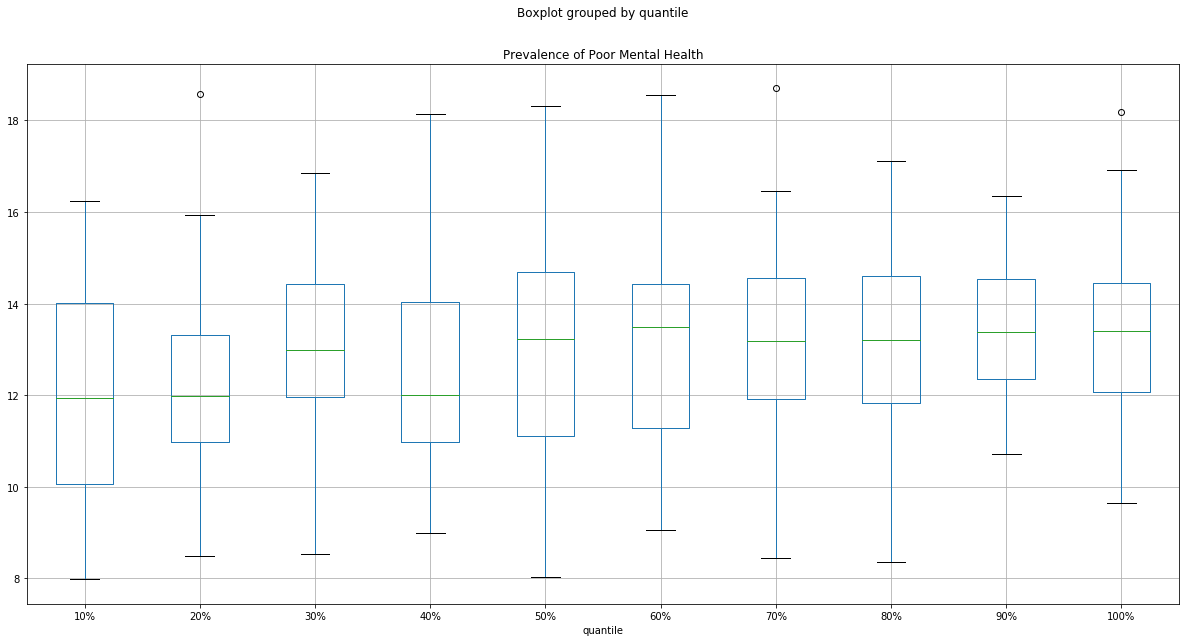

In [49]:
df.boxplot('HO_poor_mental_health', by='quantile', figsize=(20, 10))
plt.title("Prevalence of Poor Mental Health")
plt.show()

In [65]:
# Extract individual groups
group1 = df[df["quantile"] == '10%']["HO_poor_mental_health"]
group2 = df[df["quantile"] == '20%']["HO_poor_mental_health"]
group3 = df[df["quantile"] == '30%']["HO_poor_mental_health"]
group4 = df[df["quantile"] == '40%']["HO_poor_mental_health"]
group5 = df[df["quantile"] == '50%']["HO_poor_mental_health"]
group6 = df[df["quantile"] == '60%']["HO_poor_mental_health"]
group7 = df[df["quantile"] == '70%']["HO_poor_mental_health"]
group8 = df[df["quantile"] == '80%']["HO_poor_mental_health"]
group9 = df[df["quantile"] == '90%']["HO_poor_mental_health"]
group10 = df[df["quantile"] == '100%']["HO_poor_mental_health"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4, group5, group6, group7, group8, group9, group10)
print(len(group1), len(group2), len(group3), len(group4), len(group5), len(group6), len(group7), len(group8), len(group9), len(group10))

51 60 34 47 52 42 46 49 45 48


In [64]:
df_sorted = df.sort_values('quantile')
df_sorted

,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS,Quantile,quantile
82,Cicero,14.506250,15.125000,21.150000,19.643750,34.712500,36.312500,36.400000,32.006250,63.100000,45.475000,25.781250,19.637500,16,10%,10%
173,Hesperia,15.287500,15.556250,16.843750,18.418750,25.600000,29.881250,39.025000,17.031250,64.156250,54.743750,25.387500,26.506250,16,10%,10%
273,Murrieta,11.393750,10.837500,19.718750,13.862500,18.925000,25.756250,36.987500,9.575000,66.075000,69.550000,33.900000,34.906250,16,10%,10%
274,Nampa,14.621429,13.664286,14.828571,19.564286,26.307143,34.171429,33.171429,23.992857,56.485714,56.642857,33.442857,23.471429,14,10%,10%
283,New Rochelle,10.893333,11.486667,18.040000,14.073333,25.560000,23.773333,34.826667,12.126667,72.366667,67.680000,35.966667,32.200000,15,10%,10%
37,Bend,11.933333,10.550000,20.950000,15.216667,14.075000,25.941667,29.650000,8.758333,60.741667,68.591667,28.991667,31.741667,12,10%,10%
430,Tracy,12.600000,11.521429,19.642857,14.571429,21.328571,28.735714,35.657143,13.085714,61.985714,66.007143,35.557143,31.771429,14,10%,10%
345,Redondo Beach,9.192308,8.161538,20.653846,9.907692,12.084615,20.115385,32.538462,6.076923,66.784615,76.907692,35.761538,42.669231,13,10%,10%
80,Chino Hills,9.516667,8.633333,17.733333,10.441667,15.725000,20.025000,36.608333,8.141667,66.466667,72.708333,31.558333,34.791667,12,10%,10%
308,Palatine,9.673333,9.280000,24.360000,13.820000,18.400000,25.213333,31.000000,9.320000,68.606667,71.126667,40.033333,32.900000,15,10%,10%


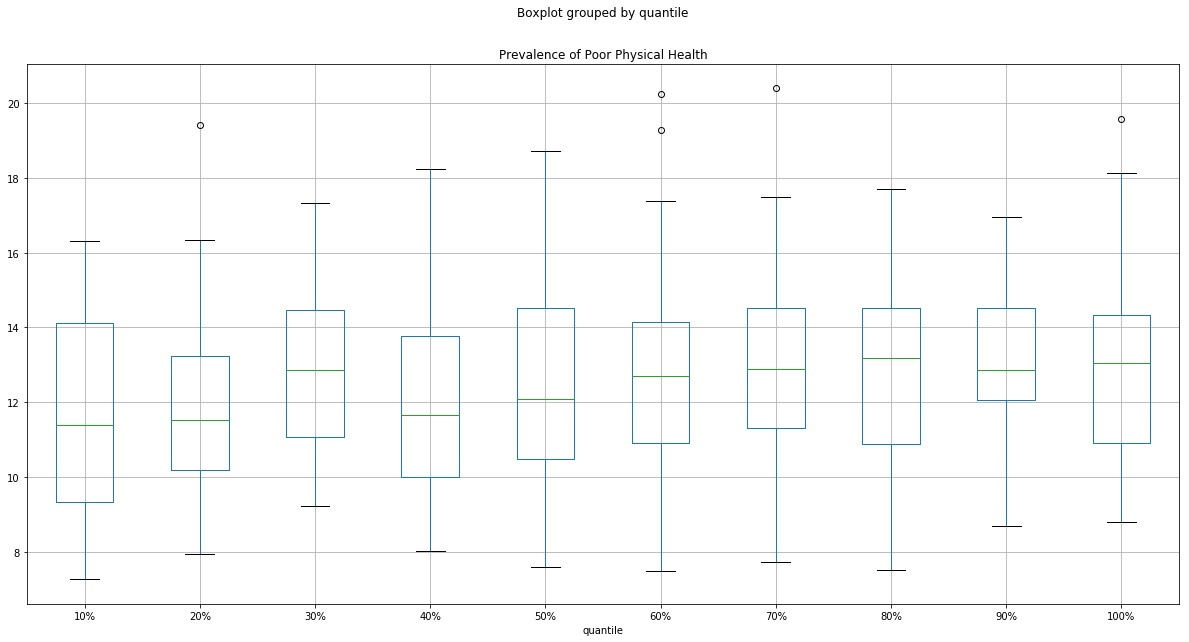

In [50]:
df.boxplot('HO_poor_physical_health', by='quantile', figsize=(20, 10))
plt.title("Prevalence of Poor Physical Health")
plt.show()

In [56]:
# Extract individual groups
group1 = df[df["quantile"] == '10%']["HO_poor_physical_health"]
group2 = df[df["quantile"] == '20%']["HO_poor_physical_health"]
group3 = df[df["quantile"] == '30%']["HO_poor_physical_health"]
group4 = df[df["quantile"] == '40%']["HO_poor_physical_health"]
group5 = df[df["quantile"] == '50%']["HO_poor_physical_health"]
group6 = df[df["quantile"] == '60%']["HO_poor_physical_health"]
group7 = df[df["quantile"] == '70%']["HO_poor_physical_health"]
group8 = df[df["quantile"] == '80%']["HO_poor_physical_health"]
group9 = df[df["quantile"] == '90%']["HO_poor_physical_health"]
group10 = df[df["quantile"] == '100%']["HO_poor_physical_health"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4, group5, group6, group7, group8, group9, group10)

F_onewayResult(statistic=2.0905585540449496, pvalue=0.028991641808668214)

## Exploring correlations between Health Outcomes and Unhealthy Behaviors
- There are NO significant differences in prevalence of binge drinking by city size (see ANOVA test)
- There are significant differences in prevalence of current smoking by city size (see ANOVA test)
- There are significant differences in prevalence of lack of physical activity by city size (see ANOVA test)
- There are significant differences in prevalence of obesity by city size (see ANOVA test)
- There are significant differences in prevalence of lack of sleep by city size (see ANOVA test)

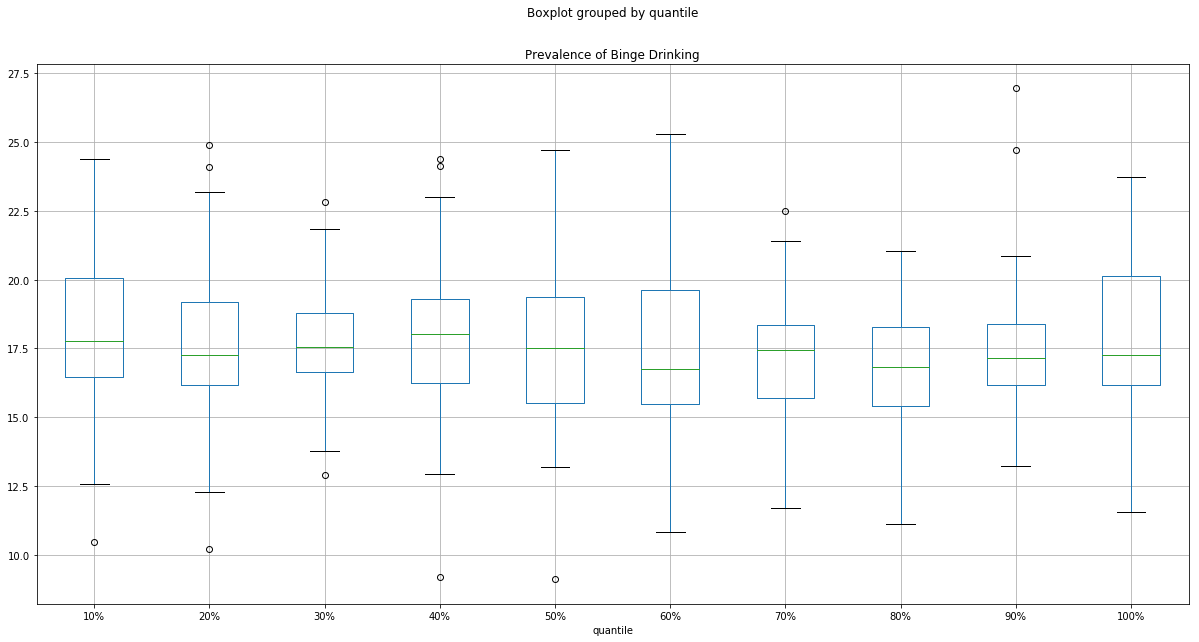

In [42]:
df.boxplot('UB_binge_drinking', by='quantile', figsize=(20, 10))
plt.title("Prevalence of Binge Drinking")
plt.show()

In [53]:
# Extract individual groups
group1 = df[df["quantile"] == '10%']["UB_binge_drinking"]
group2 = df[df["quantile"] == '20%']["UB_binge_drinking"]
group3 = df[df["quantile"] == '30%']["UB_binge_drinking"]
group4 = df[df["quantile"] == '40%']["UB_binge_drinking"]
group5 = df[df["quantile"] == '50%']["UB_binge_drinking"]
group6 = df[df["quantile"] == '60%']["UB_binge_drinking"]
group7 = df[df["quantile"] == '70%']["UB_binge_drinking"]
group8 = df[df["quantile"] == '80%']["UB_binge_drinking"]
group9 = df[df["quantile"] == '90%']["UB_binge_drinking"]
group10 = df[df["quantile"] == '100%']["UB_binge_drinking"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4, group5, group6, group7, group8, group9, group10)

F_onewayResult(statistic=0.9646737134748596, pvalue=0.46861158885000376)

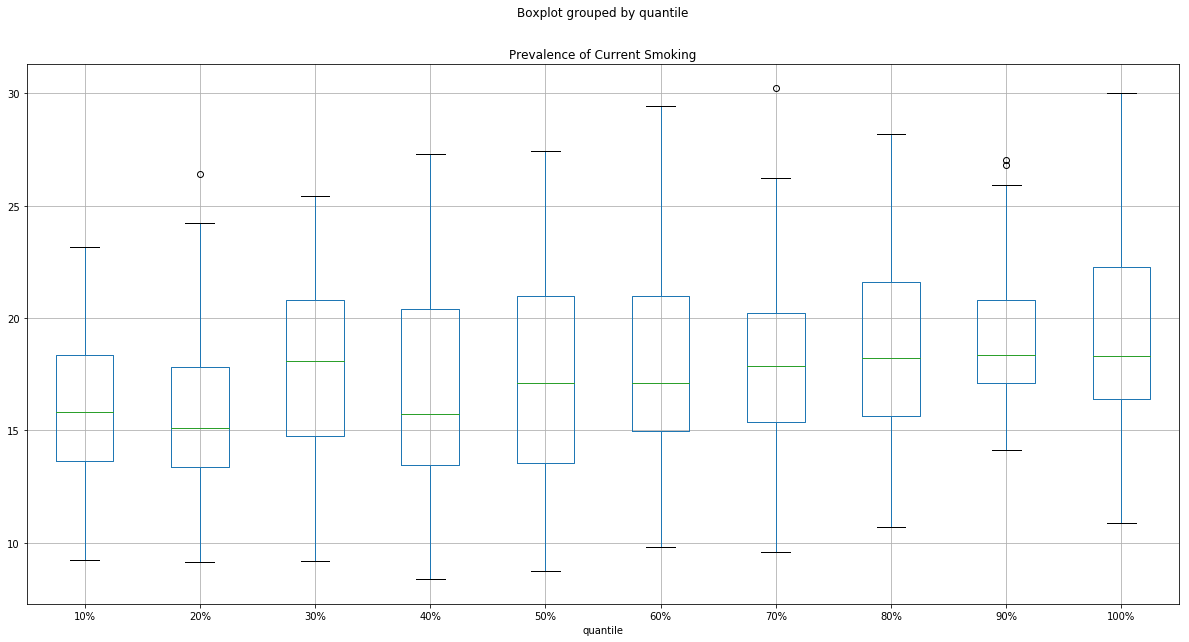

In [43]:
df.boxplot('UB_current_smoking', by='quantile', figsize=(20, 10))
plt.title("Prevalence of Current Smoking")
plt.show()

In [58]:
# Extract individual groups
group1 = df[df["quantile"] == '10%']["UB_current_smoking"]
group2 = df[df["quantile"] == '20%']["UB_current_smoking"]
group3 = df[df["quantile"] == '30%']["UB_current_smoking"]
group4 = df[df["quantile"] == '40%']["UB_current_smoking"]
group5 = df[df["quantile"] == '50%']["UB_current_smoking"]
group6 = df[df["quantile"] == '60%']["UB_current_smoking"]
group7 = df[df["quantile"] == '70%']["UB_current_smoking"]
group8 = df[df["quantile"] == '80%']["UB_current_smoking"]
group9 = df[df["quantile"] == '90%']["UB_current_smoking"]
group10 = df[df["quantile"] == '100%']["UB_current_smoking"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4, group5, group6, group7, group8, group9, group10)

F_onewayResult(statistic=4.486110070761723, pvalue=1.1503938825967078e-05)

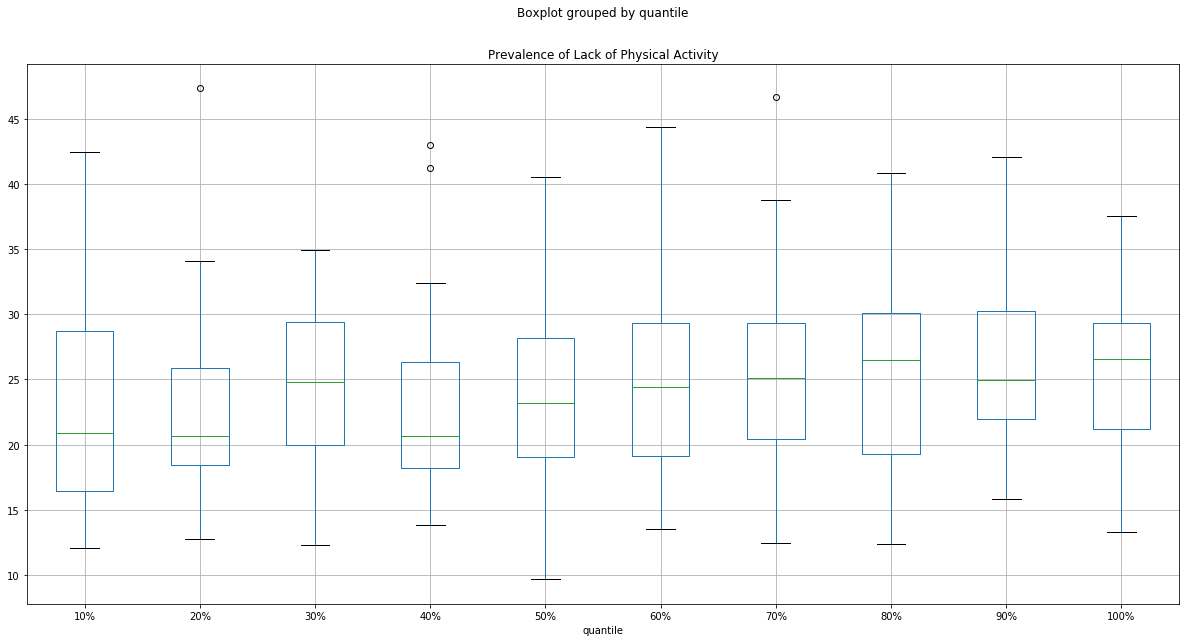

In [44]:
df.boxplot('UB_lack_physical_activity', by='quantile', figsize=(20, 10))
plt.title("Prevalence of Lack of Physical Activity")
plt.show()

In [59]:
# Extract individual groups
group1 = df[df["quantile"] == '10%']["UB_lack_physical_activity"]
group2 = df[df["quantile"] == '20%']["UB_lack_physical_activity"]
group3 = df[df["quantile"] == '30%']["UB_lack_physical_activity"]
group4 = df[df["quantile"] == '40%']["UB_lack_physical_activity"]
group5 = df[df["quantile"] == '50%']["UB_lack_physical_activity"]
group6 = df[df["quantile"] == '60%']["UB_lack_physical_activity"]
group7 = df[df["quantile"] == '70%']["UB_lack_physical_activity"]
group8 = df[df["quantile"] == '80%']["UB_lack_physical_activity"]
group9 = df[df["quantile"] == '90%']["UB_lack_physical_activity"]
group10 = df[df["quantile"] == '100%']["UB_lack_physical_activity"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4, group5, group6, group7, group8, group9, group10)

F_onewayResult(statistic=2.4823359838014816, pvalue=0.008931535035495665)

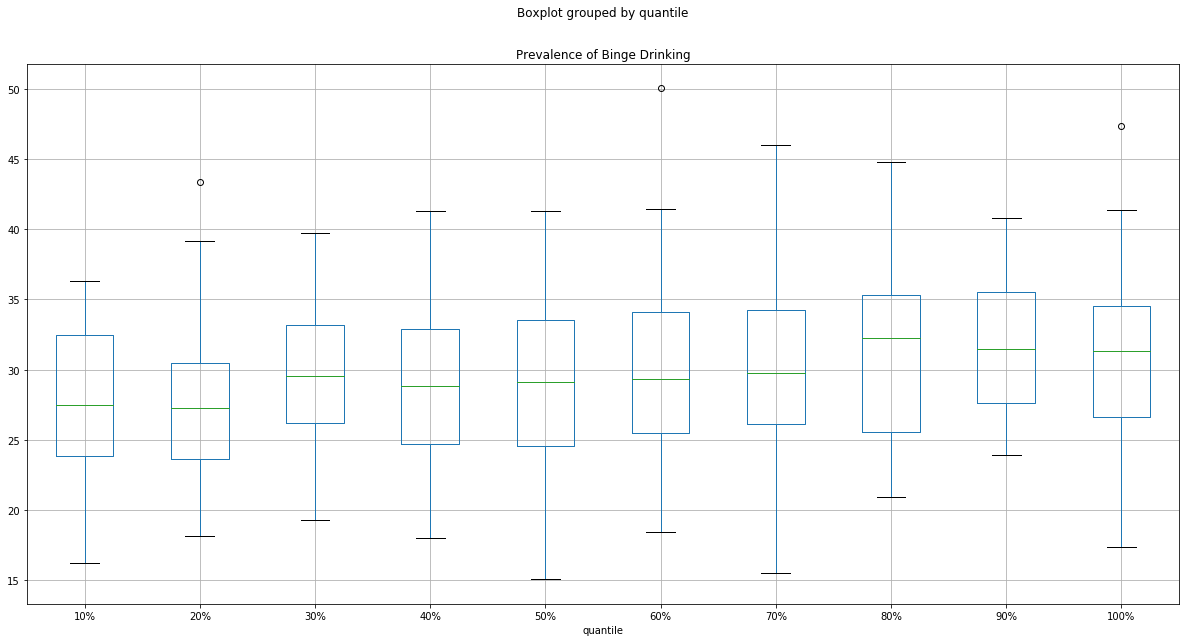

In [45]:
df.boxplot('UB_obesity', by='quantile', figsize=(20, 10))
plt.title("Prevalence of Binge Drinking")
plt.show()

In [60]:
# Extract individual groups
group1 = df[df["quantile"] == '10%']["UB_obesity"]
group2 = df[df["quantile"] == '20%']["UB_obesity"]
group3 = df[df["quantile"] == '30%']["UB_obesity"]
group4 = df[df["quantile"] == '40%']["UB_obesity"]
group5 = df[df["quantile"] == '50%']["UB_obesity"]
group6 = df[df["quantile"] == '60%']["UB_obesity"]
group7 = df[df["quantile"] == '70%']["UB_obesity"]
group8 = df[df["quantile"] == '80%']["UB_obesity"]
group9 = df[df["quantile"] == '90%']["UB_obesity"]
group10 = df[df["quantile"] == '100%']["UB_obesity"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4, group5, group6, group7, group8, group9, group10)

F_onewayResult(statistic=3.5022348350823593, pvalue=0.00033009290790769546)

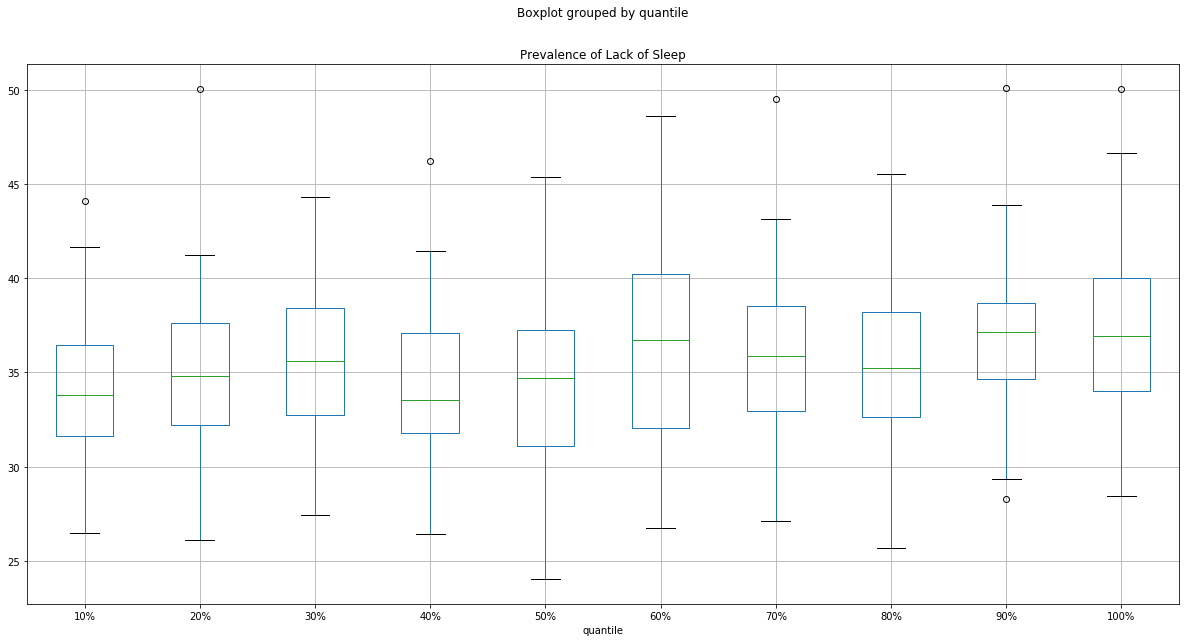

In [47]:
df.boxplot('UB_less_sleep', by='quantile', figsize=(20, 10))
plt.title("Prevalence of Lack of Sleep")
plt.show()

In [61]:
# Extract individual groups
group1 = df[df["quantile"] == '10%']["UB_less_sleep"]
group2 = df[df["quantile"] == '20%']["UB_less_sleep"]
group3 = df[df["quantile"] == '30%']["UB_less_sleep"]
group4 = df[df["quantile"] == '40%']["UB_less_sleep"]
group5 = df[df["quantile"] == '50%']["UB_less_sleep"]
group6 = df[df["quantile"] == '60%']["UB_less_sleep"]
group7 = df[df["quantile"] == '70%']["UB_less_sleep"]
group8 = df[df["quantile"] == '80%']["UB_less_sleep"]
group9 = df[df["quantile"] == '90%']["UB_less_sleep"]
group10 = df[df["quantile"] == '100%']["UB_less_sleep"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4, group5, group6, group7, group8, group9, group10)

F_onewayResult(statistic=3.163013969994102, pvalue=0.0010163381046152061)

## Exploring correlations between Health Outcomes and Unhealthy Behaviors

In [121]:
master_df.head()

,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS,cloudiness,date,humidity,temp
0,Abilene,13.608108,13.591892,17.781081,21.421622,28.840541,34.867568,33.440541,23.037838,66.354054,52.024324,31.633333,30.360000,37,75,1547865000,44,64.40
1,Akron,15.931818,15.760606,14.895455,26.824242,33.496970,36.575758,43.425758,12.612121,74.539394,52.918182,24.469697,25.065152,66,40,1547866380,81,32.00
2,Alameda,9.837500,9.400000,17.537500,11.931250,16.318750,18.675000,33.787500,7.393750,67.525000,71.312500,36.112500,35.043750,16,75,1547866560,53,62.96
3,Albany,14.903922,14.158824,15.213725,22.176471,31.519608,35.549020,42.894118,17.603922,76.454902,56.811765,30.594118,27.533333,51,90,1547866680,66,33.08
4,Albuquerque,12.455474,12.815328,15.395620,15.774453,18.538686,27.589051,32.128467,11.759124,60.380292,66.245985,40.662044,28.618248,137,1,1547866020,55,39.92


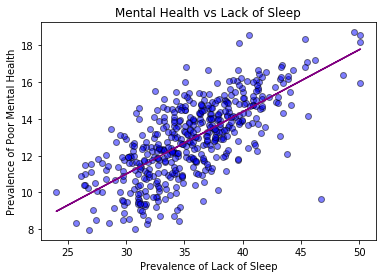

In [106]:
# Mental Health vs Lack of Sleep

#plt.scatter(master_df['UB_less_sleep'], master_df['HO_poor_physical_health'], marker='o', facecolors='blue',
#            edgecolors='black', s=master_df['tract_FIPS'])
plt.scatter(master_df['UB_less_sleep'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Lack of Sleep")
plt.xlabel("Prevalence of Lack of Sleep")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_less_sleep'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_less_sleep'], p(master_df['UB_less_sleep']), 'purple')
plt.show()

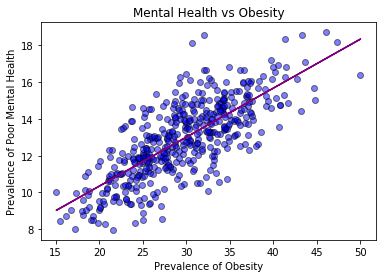

In [108]:
# Mental Health vs Obesity

plt.scatter(master_df['UB_obesity'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Obesity")
plt.xlabel("Prevalence of Obesity")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_obesity'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_obesity'], p(master_df['UB_obesity']), 'purple')
plt.show()

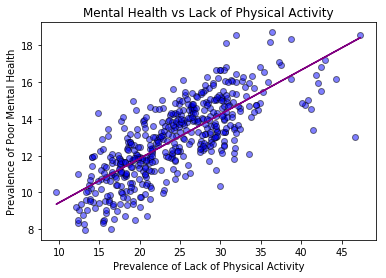

In [109]:
# Mental Health vs Lack of Physical Activity

plt.scatter(master_df['UB_lack_physical_activity'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Lack of Physical Activity")
plt.xlabel("Prevalence of Lack of Physical Activity")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_lack_physical_activity'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_lack_physical_activity'], p(master_df['UB_lack_physical_activity']), 'purple')
plt.show()

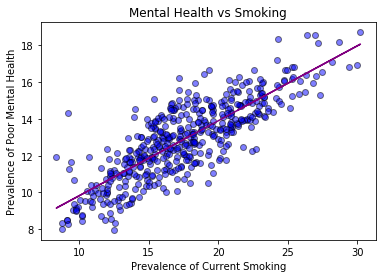

In [110]:
# Mental Health vs Current Smoking

plt.scatter(master_df['UB_current_smoking'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Smoking")
plt.xlabel("Prevalence of Current Smoking")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_current_smoking'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_current_smoking'], p(master_df['UB_current_smoking']), 'purple')
plt.show()

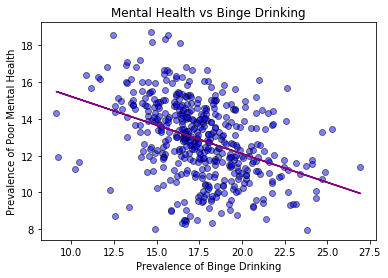

In [111]:
# Mental Health vs Binge Drinking

plt.scatter(master_df['UB_binge_drinking'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Binge Drinking")
plt.xlabel("Prevalence of Binge Drinking")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_binge_drinking'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_binge_drinking'], p(master_df['UB_binge_drinking']), 'purple')
plt.show()

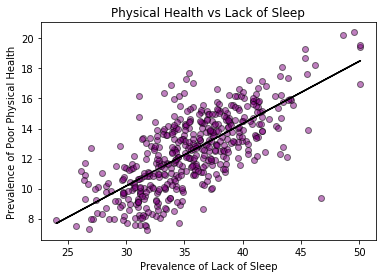

In [105]:
# Physical Health vs Lack of Sleep
plt.scatter(master_df['UB_less_sleep'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Lack of Sleep")
plt.xlabel("Prevalence of Lack of Sleep")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['UB_less_sleep'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_less_sleep'], p(master_df['UB_less_sleep']), 'black')
plt.show()

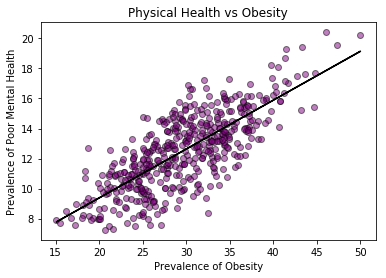

In [113]:
# Physical Health vs Obesity

plt.scatter(master_df['UB_obesity'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Obesity")
plt.xlabel("Prevalence of Obesity")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_obesity'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_obesity'], p(master_df['UB_obesity']), 'black')
plt.show()

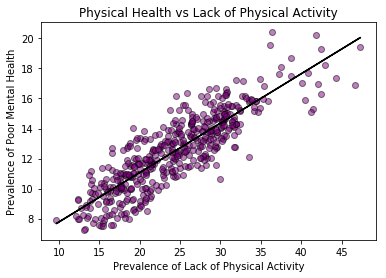

In [115]:
# Physical Health vs Lack of Physical Activity

plt.scatter(master_df['UB_lack_physical_activity'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Lack of Physical Activity")
plt.xlabel("Prevalence of Lack of Physical Activity")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_lack_physical_activity'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_lack_physical_activity'], p(master_df['UB_lack_physical_activity']), 'black')
plt.show()

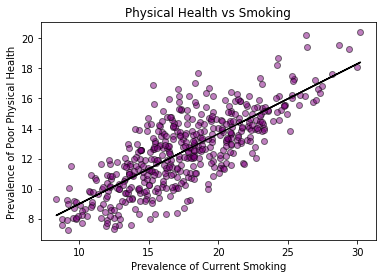

In [116]:
# Physical Health vs Current Smoking

plt.scatter(master_df['UB_current_smoking'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Smoking")
plt.xlabel("Prevalence of Current Smoking")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['UB_current_smoking'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_current_smoking'], p(master_df['UB_current_smoking']), 'black')
plt.show()

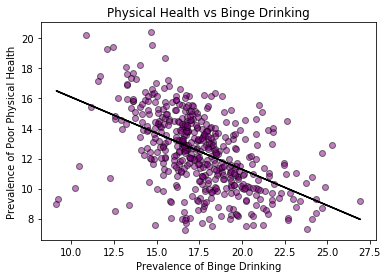

In [117]:
# Physical Health vs Binge Drinking

plt.scatter(master_df['UB_binge_drinking'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Binge Drinking")
plt.xlabel("Prevalence of Binge Drinking")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['UB_binge_drinking'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_binge_drinking'], p(master_df['UB_binge_drinking']), 'black')
plt.show()

## Exploring correlations between Health Outcomes and Preventive Services

In [122]:
master_df.head()

,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS,cloudiness,date,humidity,temp
0,Abilene,13.608108,13.591892,17.781081,21.421622,28.840541,34.867568,33.440541,23.037838,66.354054,52.024324,31.633333,30.360000,37,75,1547865000,44,64.40
1,Akron,15.931818,15.760606,14.895455,26.824242,33.496970,36.575758,43.425758,12.612121,74.539394,52.918182,24.469697,25.065152,66,40,1547866380,81,32.00
2,Alameda,9.837500,9.400000,17.537500,11.931250,16.318750,18.675000,33.787500,7.393750,67.525000,71.312500,36.112500,35.043750,16,75,1547866560,53,62.96
3,Albany,14.903922,14.158824,15.213725,22.176471,31.519608,35.549020,42.894118,17.603922,76.454902,56.811765,30.594118,27.533333,51,90,1547866680,66,33.08
4,Albuquerque,12.455474,12.815328,15.395620,15.774453,18.538686,27.589051,32.128467,11.759124,60.380292,66.245985,40.662044,28.618248,137,1,1547866020,55,39.92


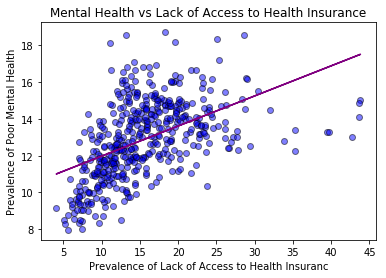

In [123]:
# Mental Health vs Lack of Access to Health Insurance
plt.scatter(master_df['PS_lack_health_ins'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Lack of Access to Health Insurance")
plt.xlabel("Prevalence of Lack of Access to Health Insurance")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['PS_lack_health_ins'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['PS_lack_health_ins'], p(master_df['PS_lack_health_ins']), 'purple')
plt.show()

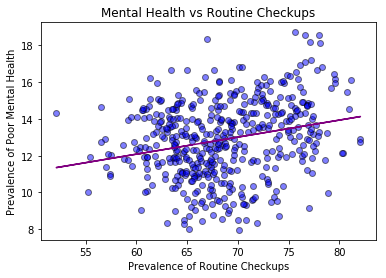

In [124]:
# Mental Health vs Routine Checkups
plt.scatter(master_df['PS_routine_checkups'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Routine Checkups")
plt.xlabel("Prevalence of Routine Checkups")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['PS_routine_checkups'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['PS_routine_checkups'], p(master_df['PS_routine_checkups']), 'purple')
plt.show()

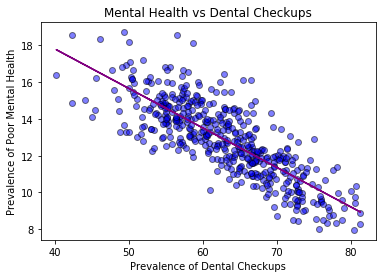

In [125]:
# Mental Health vs Dental Checkups
plt.scatter(master_df['PS_dental_checkups'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Dental Checkups")
plt.xlabel("Prevalence of Dental Checkups")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['PS_dental_checkups'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['PS_dental_checkups'], p(master_df['PS_dental_checkups']), 'purple')
plt.show()

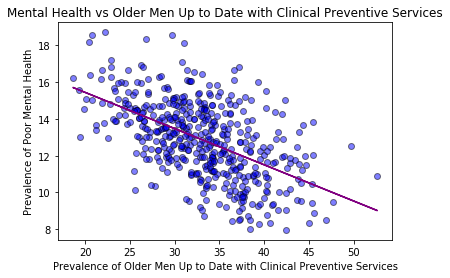

In [126]:
# Mental Health vs Older Men Up to Date with Clinical Preventive Services
plt.scatter(master_df['PS_older_men_uptodate'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Older Men Up to Date with Clinical Preventive Services")
plt.xlabel("Prevalence of Older Men Up to Date with Clinical Preventive Services")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['PS_older_men_uptodate'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['PS_older_men_uptodate'], p(master_df['PS_older_men_uptodate']), 'purple')
plt.show()

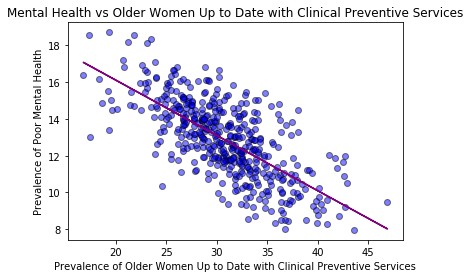

In [127]:
# Mental Health vs Older Women Up to Date with Clinical Preventive Services
plt.scatter(master_df['PS_older_women_uptodate'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Older Women Up to Date with Clinical Preventive Services")
plt.xlabel("Prevalence of Older Women Up to Date with Clinical Preventive Services")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['PS_older_women_uptodate'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['PS_older_women_uptodate'], p(master_df['PS_older_women_uptodate']), 'purple')
plt.show()

## Exploring correlations between Health Outcomes and Population

In [128]:
master_df.head()

,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS,cloudiness,date,humidity,temp
0,Abilene,13.608108,13.591892,17.781081,21.421622,28.840541,34.867568,33.440541,23.037838,66.354054,52.024324,31.633333,30.360000,37,75,1547865000,44,64.40
1,Akron,15.931818,15.760606,14.895455,26.824242,33.496970,36.575758,43.425758,12.612121,74.539394,52.918182,24.469697,25.065152,66,40,1547866380,81,32.00
2,Alameda,9.837500,9.400000,17.537500,11.931250,16.318750,18.675000,33.787500,7.393750,67.525000,71.312500,36.112500,35.043750,16,75,1547866560,53,62.96
3,Albany,14.903922,14.158824,15.213725,22.176471,31.519608,35.549020,42.894118,17.603922,76.454902,56.811765,30.594118,27.533333,51,90,1547866680,66,33.08
4,Albuquerque,12.455474,12.815328,15.395620,15.774453,18.538686,27.589051,32.128467,11.759124,60.380292,66.245985,40.662044,28.618248,137,1,1547866020,55,39.92


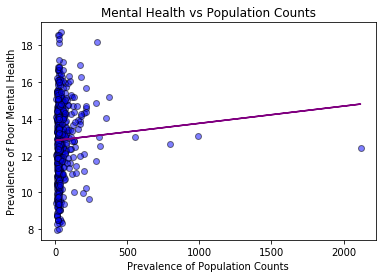

In [130]:
# Mental Health vs Population Counts

plt.scatter(master_df['tract_FIPS'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Population Counts")
plt.xlabel("Prevalence of Population Counts")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['tract_FIPS'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['tract_FIPS'], p(master_df['tract_FIPS']), 'purple')
plt.show()

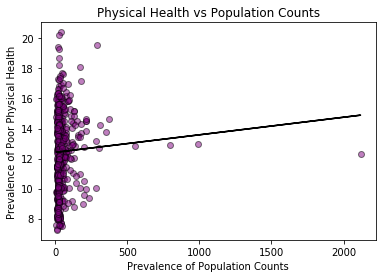

In [131]:
# Physical Health vs Population Counts

plt.scatter(master_df['tract_FIPS'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Population Counts")
plt.xlabel("Prevalence of Population Counts")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['tract_FIPS'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['tract_FIPS'], p(master_df['tract_FIPS']), 'black')
plt.show()

In [ ]:
# Physical Health vs Obesity

plt.scatter(master_df['UB_obesity'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Obesity")
plt.xlabel("Prevalence of Obesity")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['UB_obesity'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['UB_obesity'], p(master_df['UB_obesity']), 'black')
plt.show()

## Exploring correlations between Health Outcomes and Weather

In [133]:
master_df.head()

,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS,cloudiness,date,humidity,temp
0,Abilene,13.608108,13.591892,17.781081,21.421622,28.840541,34.867568,33.440541,23.037838,66.354054,52.024324,31.633333,30.360000,37,75,1547865000,44,64.40
1,Akron,15.931818,15.760606,14.895455,26.824242,33.496970,36.575758,43.425758,12.612121,74.539394,52.918182,24.469697,25.065152,66,40,1547866380,81,32.00
2,Alameda,9.837500,9.400000,17.537500,11.931250,16.318750,18.675000,33.787500,7.393750,67.525000,71.312500,36.112500,35.043750,16,75,1547866560,53,62.96
3,Albany,14.903922,14.158824,15.213725,22.176471,31.519608,35.549020,42.894118,17.603922,76.454902,56.811765,30.594118,27.533333,51,90,1547866680,66,33.08
4,Albuquerque,12.455474,12.815328,15.395620,15.774453,18.538686,27.589051,32.128467,11.759124,60.380292,66.245985,40.662044,28.618248,137,1,1547866020,55,39.92


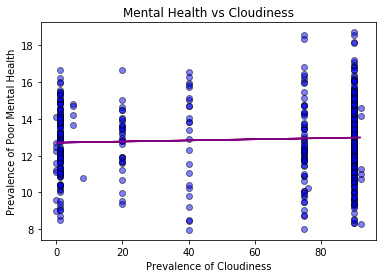

In [132]:
# Mental Health vs Cloudiness

plt.scatter(master_df['cloudiness'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Cloudiness")
plt.xlabel("Cloudiness")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['cloudiness'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['cloudiness'], p(master_df['cloudiness']), 'purple')
plt.show()

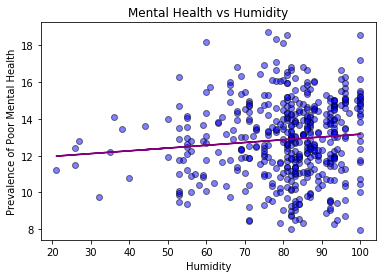

In [134]:
# Mental Health vs Humidity

plt.scatter(master_df['humidity'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Humidity")
plt.xlabel("Humidity")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['humidity'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['humidity'], p(master_df['humidity']), 'purple')
plt.show()

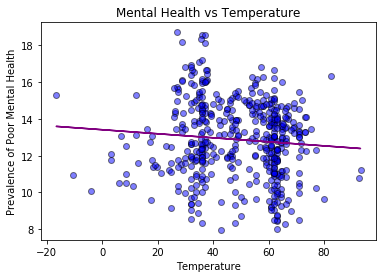

In [135]:
# Mental Health vs Temperature

plt.scatter(master_df['temp'], master_df['HO_poor_mental_health'], marker='o', facecolors='blue',
            edgecolors='black', alpha=0.5)
plt.title("Mental Health vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Prevalence of Poor Mental Health")

#adding a trendline
z = np.polyfit(master_df['temp'], master_df['HO_poor_mental_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['temp'], p(master_df['temp']), 'purple')
plt.show()

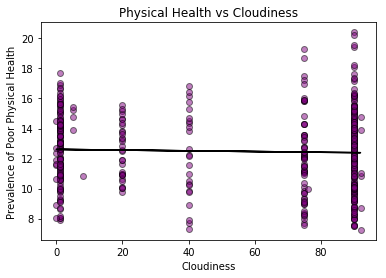

In [137]:
# Physical Health vs Cloudiness

plt.scatter(master_df['cloudiness'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Cloudiness")
plt.xlabel("Cloudiness")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['cloudiness'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['cloudiness'], p(master_df['cloudiness']), 'black')
plt.show()

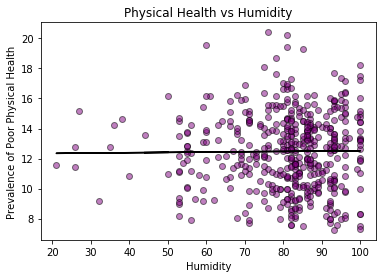

In [138]:
# Physical Health vs Humidity

plt.scatter(master_df['humidity'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Humidity")
plt.xlabel("Humidity")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['humidity'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['humidity'], p(master_df['humidity']), 'black')
plt.show()

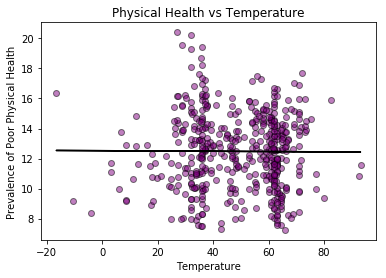

In [139]:
# Physical Health vs Temperature

plt.scatter(master_df['temp'], master_df['HO_poor_physical_health'], marker='o', facecolors='purple',
            edgecolors='black', alpha=0.5)
plt.title("Physical Health vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Prevalence of Poor Physical Health")

#adding a trendline
z = np.polyfit(master_df['temp'], master_df['HO_poor_physical_health'], 1)
p = np.poly1d(z)
plt.plot(master_df['temp'], p(master_df['temp']), 'black')
plt.show()

## For potential use...

In [ ]:
# Plot state means with error bars
#cities_lst = list(state_HO_poor_mental_health.city)
#means_lst = list(state_HO_poor_mental_health['mean'])
#std_lst = list(state_HO_poor_mental_health['std'])

#fig, ax = plt.subplots()
#ax.errorbar(cities_lst, means_lst, yerr=std_lst, fmt='o', color='b', alpha=0.5,
#            label='Mean of Prevalence of Poor Mental Health')
#plt.show()

In [55]:
mod = ols('SLEEP_CrudePrev ~ PlaceName', data=tracts_4cities).fit()
aov_table_1 = sm.stats.anova_lm(mod, typ=2)
print(aov_table_1)

                 sum_sq      df          F         PR(>F)
PlaceName  23557.786181     3.0  323.48552  3.242181e-188
Residual   97949.430347  4035.0        NaN            NaN


In [56]:
mod = ols('MHLTH_CrudePrev ~ PlaceName', data=tracts_4cities).fit()
aov_table_2 = sm.stats.anova_lm(mod, typ=2)
print(aov_table_2)

                 sum_sq      df          F        PR(>F)
PlaceName   1161.481998     3.0  42.518621  4.806908e-27
Residual   36741.391550  4035.0        NaN           NaN
